# MLP MNIST Pytorch
林峻弘 2019280374

> Import torch and libraries



In [0]:
import os
import torch
from torch import nn
from torch.nn import functional as fc
import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets as ds
from torchvision import transforms as tf
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler as SR
%matplotlib inline
torch.cuda.set_device(0)

Data Process

In [2]:
num_workers = 0
batch_size = 20
valid_size = 0.2
transform = tf.ToTensor()
train_data = ds.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = ds.MNIST(root = 'data', train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                            num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


#Define Network

In [0]:
class MLP(nn.Module):
    def __init__(self):
      super(MLP,self).__init__()
      hidden_1 = 1024
      hidden_2 = 1024
      self.fc_1 = nn.Linear(28*28, 1024)
      self.fc_2 = nn.Linear(1024,1024)
      self.fc_3 = nn.Linear(1024,10)
      self.dropout = nn.Dropout(0.3)
    
    def forward (self,Input):
      Input = Input.view(Input.size(0),-1)
      out = fc.relu(self.fc_1(Input))
      out = self.dropout(out)
      out = fc.relu(self.fc_2(out))
      out = self.dropout(out)
      out = self.fc_3(out)
      return out


In [4]:
model = MLP()
print(model)


MLP(
  (fc_1): Linear(in_features=784, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [0]:
criterion = nn.CrossEntropyLoss()
alpha = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr = alpha)

In [6]:
epochs = 20
train_loss = []
validation_losses = []
validation_acc = []
for epoch in range(epochs):
    training_loss = 0
    accuracy =0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        training_loss = training_loss + loss.item()
    
    model.eval()
    for data,label in valid_loader:
        output = model(data)
        loss = criterion(output,label)
        validation_loss = loss.item()
        top_p,top_class = output.topk(1,dim=1)
        same = top_class == label.view(*top_class.shape)
        accuracy += torch.mean(same.type(torch.FloatTensor))
    train_loss.append(training_loss/len(train_loader))
    validation_losses.append(validation_loss/len(valid_loader))
    validation_acc.append(accuracy/len(valid_loader))

    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(training_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
          "Validation Accuracy: {:.3f}.. ".format(accuracy/len(valid_loader)))


Epoch: 1/20..  Training Loss: 2.182..  Validation Loss: 0.001..  Validation Accuracy: 0.702.. 
Epoch: 2/20..  Training Loss: 1.535..  Validation Loss: 0.000..  Validation Accuracy: 0.779.. 
Epoch: 3/20..  Training Loss: 0.854..  Validation Loss: 0.000..  Validation Accuracy: 0.834.. 
Epoch: 4/20..  Training Loss: 0.624..  Validation Loss: 0.000..  Validation Accuracy: 0.861.. 
Epoch: 5/20..  Training Loss: 0.524..  Validation Loss: 0.000..  Validation Accuracy: 0.877.. 
Epoch: 6/20..  Training Loss: 0.468..  Validation Loss: 0.000..  Validation Accuracy: 0.887.. 
Epoch: 7/20..  Training Loss: 0.433..  Validation Loss: 0.000..  Validation Accuracy: 0.893.. 
Epoch: 8/20..  Training Loss: 0.406..  Validation Loss: 0.000..  Validation Accuracy: 0.899.. 
Epoch: 9/20..  Training Loss: 0.385..  Validation Loss: 0.000..  Validation Accuracy: 0.903.. 
Epoch: 10/20..  Training Loss: 0.367..  Validation Loss: 0.000..  Validation Accuracy: 0.906.. 
Epoch: 11/20..  Training Loss: 0.355..  Validatio

# Test the model

In [7]:
testing_loss =[]
correct = 0
total = 0
with torch.no_grad():
    for data,label in test_loader:
        test_loss=0
        output = model(data)
        loss = criterion(output,label)
        test_loss = test_loss + loss.item()
        _,pred = torch.max(output,1)
        total += label.size(0)
        correct += (pred == label).sum().item()
    testing_loss.append(test_loss/len(test_loader))
    print('Accuracy: %.2f %%'%(100*correct/total))
    print("Testing Loss: {:.3f}.. ".format(test_loss/len(test_loader)))



Accuracy: 93.29 %
Testing Loss: 0.001.. 


# Plot Diagram

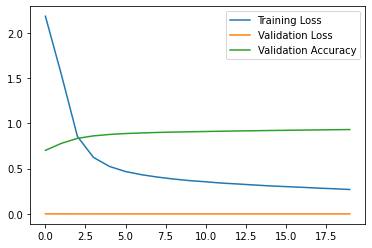

In [8]:
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.plot(validation_acc,label='Validation Accuracy')
plt.legend(frameon=True)
